<a href="https://colab.research.google.com/github/yeonmi02/dlproject/blob/main/dlproject_data_MLP_TabNet_Entity_Embedding_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 불러오기

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


patient = pd.read_csv('/content/drive/MyDrive/hospital data analysis.csv')
patient.head(10)

,Patient_ID,Age,Gender,Condition,Procedure,Cost,Length_of_Stay,Readmission,Outcome,Satisfaction
0,1,45,Female,Heart Disease,Angioplasty,15000,5,No,Recovered,4
1,2,60,Male,Diabetes,Insulin Therapy,2000,3,Yes,Stable,3
2,3,32,Female,Fractured Arm,X-Ray and Splint,500,1,No,Recovered,5
3,4,75,Male,Stroke,CT Scan and Medication,10000,7,Yes,Stable,2
4,5,50,Female,Cancer,Surgery and Chemotherapy,25000,10,No,Recovered,4
5,6,68,Male,Hypertension,Medication and Counseling,1000,2,No,Stable,4
6,7,55,Female,Appendicitis,Appendectomy,8000,4,No,Recovered,3
7,8,40,Male,Fractured Leg,Cast and Physical Therapy,3000,6,No,Recovered,4
8,9,70,Female,Heart Attack,Cardiac Catheterization,18000,8,Yes,Stable,2
9,10,25,Male,Allergic Reaction,Epinephrine Injection,100,1,No,Recovered,5


# 데이터 전처리 하기

In [184]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [185]:
print(patient.columns.tolist())

['Patient_ID', 'Age', 'Gender', 'Condition', 'Procedure', 'Cost', 'Length_of_Stay', 'Readmission', 'Outcome', 'Satisfaction']


In [186]:
if 'Patient_ID' in patient.columns:
    patient.drop(columns=['Patient_ID'], inplace=True)

In [187]:
patient.fillna({
    'Age': patient['Age'].median(),
    'Gender': patient['Gender'].mode()[0],
    'Condition': 'Unknown',
    'Procedure': 'Unknown',
    'Cost': patient['Cost'].median(),
    'Length_of_Stay': patient['Length_of_Stay'].median(),
    'Readmission': 'No',
    'Outcome': 'Unknown',
    'Satisfaction': patient['Satisfaction'].mode()[0]
}, inplace=True)

In [188]:
le = LabelEncoder()
patient['Outcome_Label'] = le.fit_transform(patient['Outcome'])

In [189]:
categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission']
patient = pd.get_dummies(patient, columns=categorical_cols)

In [190]:
patient.drop(columns=[col for col in patient.columns if col.startswith('Outcome_')], inplace=True)

In [191]:
# 원핫인코딩
X = patient.drop(columns=['Outcome'])
y = patient['Outcome']

In [192]:
# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [193]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [194]:
print("데이터 전처리 완료함")
print("X_train shape:", X_train.shape)
print("y label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

데이터 전처리 완료함
X_train shape: (787, 38)
y label mapping: {'Recovered': np.int64(0), 'Stable': np.int64(1)}


In [195]:
X_scaled.shape
y.shape

(984,)

In [196]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [197]:
print(type(y_train))
print(y_train[:10])
print([type(x) for x in y_train[:10]])

<class 'pandas.core.series.Series'>
507       Stable
345       Stable
933       Stable
71     Recovered
544    Recovered
645       Stable
532       Stable
905       Stable
658    Recovered
562       Stable
Name: Outcome, dtype: object
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [198]:
# 라벨 값 종류 확인
print("라벨 종류:", patient['Outcome'].unique())

# 라벨 분포
print("라벨 분포:")
print(patient['Outcome'].value_counts())

# 결측치 확인
missing_labels = patient['Outcome'].isnull().sum()
print(f"라벨 결측치 개수: {missing_labels}")

라벨 종류: ['Recovered' 'Stable']
라벨 분포:
Outcome
Recovered    591
Stable       393
Name: count, dtype: int64
라벨 결측치 개수: 0


In [199]:
import pandas as pd

print("Train 라벨 분포:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest 라벨 분포:")
print(pd.Series(y_test).value_counts(normalize=True))

Train 라벨 분포:
Outcome
Recovered    0.601017
Stable       0.398983
Name: proportion, dtype: float64

Test 라벨 분포:
Outcome
Recovered    0.598985
Stable       0.401015
Name: proportion, dtype: float64


In [239]:
import numpy as np

# 만약 DataFrame/Series라면 넘파이 배열로 변환
if 'pandas' in str(type(X_train)):
    X_train = X_train.to_numpy(dtype=np.float32)
    X_test = X_test.to_numpy(dtype=np.float32)

if 'pandas' in str(type(y_train)):
    # 문자열 라벨 -> 숫자 라벨로 변환하는 예시 (binary case)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # 넘파이 배열로 변환
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

# 다층 퍼셉트론 모델 구현하기

In [231]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [237]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류 출력층
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [240]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=2
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 - 2s - 75ms/step - accuracy: 0.8590 - loss: 0.4539 - val_accuracy: 0.9949 - val_loss: 0.2553
Epoch 2/25
25/25 - 1s - 55ms/step - accuracy: 1.0000 - loss: 0.1578 - val_accuracy: 1.0000 - val_loss: 0.0841
Epoch 3/25
25/25 - 3s - 102ms/step - accuracy: 1.0000 - loss: 0.0497 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 4/25
25/25 - 1s - 54ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0126
Epoch 5/25
25/25 - 3s - 102ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 6/25
25/25 - 3s - 133ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 7/25
25/25 - 2s - 79ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/25
25/25 - 3s - 115ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 9/25
25/25 - 2s - 76ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 10/25
25/25

In [241]:
# 3. 예측 및 평가 (threshold=0.5)
y_train_pred = (model.predict(X_train) >= 0.5).astype(int).reshape(-1)
y_test_pred = (model.predict(X_test) >= 0.5).astype(int).reshape(-1)

print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


In [242]:
from sklearn.metrics import classification_report, confusion_matrix

# 훈련 데이터셋 예측
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# 테스트 데이터셋 예측
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# 훈련 데이터셋 평가
print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

# 테스트 데이터셋 평가
print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


##  * 문제점

- 과적합 된 가능성이 있어서 데이터 양을 늘리는 방향으로 해결해볼 수 있다







In [243]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# X_train, y_train: 훈련 데이터
print("Before SMOTE:", Counter(y_train))

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

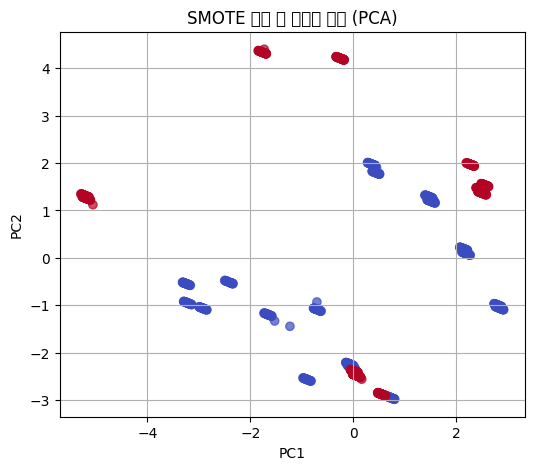

In [244]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='coolwarm', alpha=0.7)
plt.title('SMOTE 적용 후 데이터 분포 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [245]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


In [246]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 기존 모델 초기화 (간단 예시, 네트워크는 네가 쓰던 걸로 바꿔도 돼)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류일 경우

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 재훈련
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7359 - loss: 0.5833 - val_accuracy: 1.0000 - val_loss: 0.2513
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 - loss: 0.2022 - val_accuracy: 1.0000 - val_loss: 0.0770
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 1.0000 - loss: 0.0626 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 -

In [247]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred_train = model.predict(X_train_resampled).round()
y_pred_test = model.predict(X_test).round()

# 평가 지표 출력
print("Train 데이터 성능:")
print(classification_report(y_train_resampled, y_pred_train))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train_resampled, y_pred_train))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_pred_test))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_pred_test))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       473

    accuracy                           1.00       946
   macro avg       1.00      1.00      1.00       946
weighted avg       1.00      1.00      1.00       946

Train 데이터 혼동 행렬:
[[473   0]
 [  0 473]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


## 교차검증 해보기

In [248]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier  # 또는 사용하는 모델로 교체
import numpy as np

In [250]:
X = patient.drop(columns=['Outcome'])
y = patient['Outcome']

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

all_y_true = []
all_y_pred = []

In [253]:
for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # SMOTE를 학습 세트에만 적용
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # 모델 학습
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)

In [255]:
    # 예측 및 평가
    y_pred = model.predict(X_test)

    print(f"Fold {fold} 결과:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    fold += 1

Fold 2 결과:
[[118   0]
 [  0  78]]
              precision    recall  f1-score   support

   Recovered       1.00      1.00      1.00       118
      Stable       1.00      1.00      1.00        78

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



In [256]:
# 전체 평균 성능
print("전체 Fold 평균 결과:")
print(confusion_matrix(all_y_true, all_y_pred))
print(classification_report(all_y_true, all_y_pred))

전체 Fold 평균 결과:
[[236   0]
 [  0 156]]
              precision    recall  f1-score   support

   Recovered       1.00      1.00      1.00       236
      Stable       1.00      1.00      1.00       156

    accuracy                           1.00       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      1.00      1.00       392



# MLP 모델 구현 후기

### 1. 우선 데이터 셋의 양이 적어서 그런건지 아닌지 모르겠지만 과적합이 의심되는 결과가 나타나고 있고 데이터 셋도 늘려봤지만 성능이 100%로 그대로여서 소용이 없었습니다.

### 2. 정말 데이터가 잘 학습되고 모델이 잘 형성되어서 성능이 완벽한 MLP가 만들어진 것인지 모르겠어서 다른 모델로도 학습을 해보려고 합니다.

# TabNet 모델 구현하기

In [257]:
# TabNet 라이브러리 설치
!pip install pytorch-tabnet

In [258]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report
import torch
from sklearn.preprocessing import LabelEncoder

In [259]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [260]:
# 데이터 넘파이 배열로 바꿈
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

In [261]:
# gpu가능 여부
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [262]:
# 모델 구현 및 학습
clf = TabNetClassifier(
    device_name=device.type,
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83758 | test_accuracy: 0.4898  |  0:00:01s
epoch 1  | loss: 0.37828 | test_accuracy: 0.46939 |  0:00:02s
epoch 2  | loss: 0.37995 | test_accuracy: 0.44388 |  0:00:03s
epoch 3  | loss: 0.1309  | test_accuracy: 0.42347 |  0:00:03s
epoch 4  | loss: 0.04893 | test_accuracy: 0.42347 |  0:00:04s
epoch 5  | loss: 0.03625 | test_accuracy: 0.47449 |  0:00:05s
epoch 6  | loss: 0.01171 | test_accuracy: 0.46939 |  0:00:07s
epoch 7  | loss: 0.02636 | test_accuracy: 0.56122 |  0:00:07s
epoch 8  | loss: 0.01302 | test_accuracy: 0.60204 |  0:00:08s
epoch 9  | loss: 0.01685 | test_accuracy: 0.55102 |  0:00:09s
epoch 10 | loss: 0.00631 | test_accuracy: 0.54592 |  0:00:10s
epoch 11 | loss: 0.02351 | test_accuracy: 0.64796 |  0:00:10s
epoch 12 | loss: 0.02349 | test_accuracy: 0.65816 |  0:00:11s
epoch 13 | loss: 0.00767 | test_accuracy: 0.63265 |  0:00:13s
epoch 14 | loss: 0.00405 | test_accuracy: 0.58163 |  0:00:14s
epoch 15 | loss: 0.00217 | test_accuracy: 0.58163 |  0:00:16s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [263]:
# 평가
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        78

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



In [264]:
# 예측 확률
proba = clf.predict_proba(X_test)

recovered_idx = list(le.classes_).index("Recovered")

# 치료 가능성
recovered_proba = proba[:, recovered_idx]

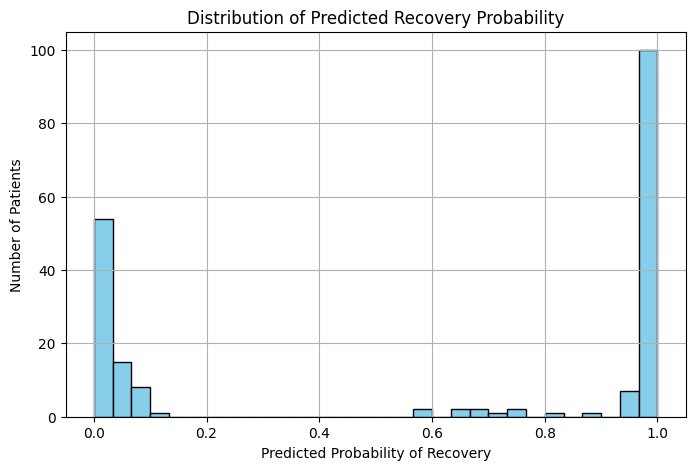

In [265]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(recovered_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Recovery Probability")
plt.xlabel("Predicted Probability of Recovery")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


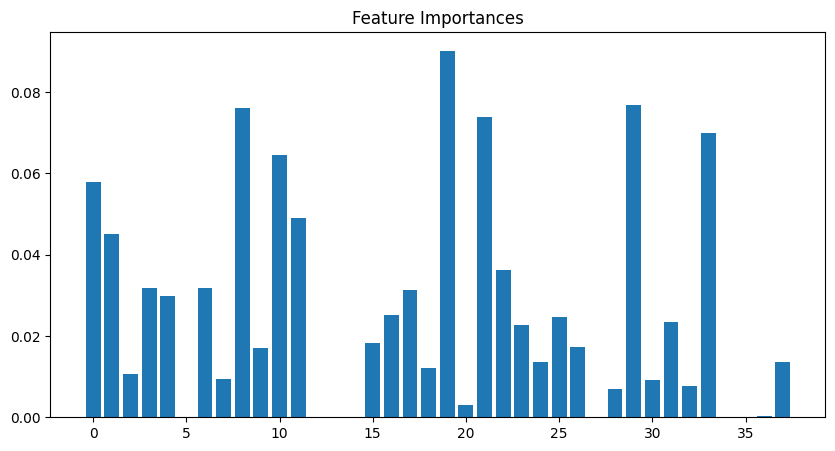

In [266]:
# 시각화
plt.figure(figsize=(10, 5))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.show()

## * 문제점 : MLP와 역시 과적합 문제 발생

1. SMOTE을 사용하는 방식의 오류일 수 있으므로 올바르게 조정한다
2. 하이퍼파라미터 조정 방식으로 문제 해결

In [269]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [270]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(
    n_d=8, n_a=8,          # 피처 처리 단위 감소 (기본은 64)
    n_steps=3,             # 레이어 깊이 줄임
    gamma=1.3,             # 주의 집중 계수
    lambda_sparse=1e-4,    # 희소성 유도
    optimizer_params=dict(lr=2e-2),  # 과적합 방지를 위한 학습률 조정
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',    # 일반적으로 entmax가 softmax보다 안정적
    verbose=1,
    seed=42
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


## * 모델 학습 오류로 변환 다시 실행

In [274]:
print(X_train_res.dtypes)
print(X_train_res.isnull().sum())  # 결측치도 확인

# 숫자형으로 변환 (예: 범주형 -> 숫자형 인코딩)
# 예를 들어 Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))

# 결측치 처리도 필요하면 (평균 대체 등)
X_train_res = X_train_res.fillna(0)

# 테스트 데이터도 동일하게 처리
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))
X_test = X_test.fillna(0)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [277]:
print(X_train_res.dtypes)        # 각 컬럼 데이터 타입 확인
print(X_train_res.isnull().sum())  # 결측치 체크
print(X_train_res.head())

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [278]:
from sklearn.preprocessing import LabelEncoder

for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))

for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))

In [279]:
X_train_res = X_train_res.fillna(0)
X_test = X_test.fillna(0)

In [290]:
print(X_train_res.dtypes)  # 각 컬럼 타입 꼼꼼히 확인
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                     int64
Gender_Male                                       int64
Condition_Allergic Reaction                       int64
Condition_Appendicitis                            int64
Condition_Cancer                                  int64
Condition_Childbirth                              int64
Condition_Diabetes                                int64
Condition_Fractured Arm                           int64
Condition_Fractured Leg                           int64
Condition_Heart Attack                            int64
Condition_Heart Disease                           int64
Condition_Hypertension                            int64
Condition_Kidney Stones                           int64
Condition_Osteoarthritis                        

In [291]:
bool_cols = X_train_res.select_dtypes(include=['bool']).columns
X_train_res[bool_cols] = X_train_res[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [289]:
print(X_train_res.dtypes)  # bool이 int로 바뀌었는지 확인
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                     int64
Gender_Male                                       int64
Condition_Allergic Reaction                       int64
Condition_Appendicitis                            int64
Condition_Cancer                                  int64
Condition_Childbirth                              int64
Condition_Diabetes                                int64
Condition_Fractured Arm                           int64
Condition_Fractured Leg                           int64
Condition_Heart Attack                            int64
Condition_Heart Disease                           int64
Condition_Hypertension                            int64
Condition_Kidney Stones                           int64
Condition_Osteoarthritis                        

In [284]:
clf.fit(
    X_train_res.values, y_train_res.values,
    eval_set=[(X_train_res.values, y_train_res.values), (X_test.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.76786 | train_accuracy: 0.37738 | valid_accuracy: 0.28934 |  0:00:00s
epoch 1  | loss: 0.41146 | train_accuracy: 0.30973 | valid_accuracy: 0.30964 |  0:00:00s
epoch 2  | loss: 0.18341 | train_accuracy: 0.43235 | valid_accuracy: 0.41624 |  0:00:00s
epoch 3  | loss: 0.06209 | train_accuracy: 0.67653 | valid_accuracy: 0.62944 |  0:00:01s
epoch 4  | loss: 0.02219 | train_accuracy: 0.72199 | valid_accuracy: 0.63452 |  0:00:01s
epoch 5  | loss: 0.00407 | train_accuracy: 0.72516 | valid_accuracy: 0.69036 |  0:00:02s
epoch 6  | loss: 0.00154 | train_accuracy: 0.73044 | valid_accuracy: 0.70051 |  0:00:02s
epoch 7  | loss: 0.00094 | train_accuracy: 0.68076 | valid_accuracy: 0.69543 |  0:00:02s
epoch 8  | loss: 0.00086 | train_accuracy: 0.64059 | valid_accuracy: 0.6599  |  0:00:03s
epoch 9  | loss: 0.00044 | train_accuracy: 0.62474 | valid_accuracy: 0.71574 |  0:00:03s
epoch 10 | loss: 0.00027 | train_accuracy: 0.64271 | valid_accuracy: 0.73096 |  0:00:03s
epoch 11 | loss: 0.00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [285]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 예측 (테스트 데이터)
y_pred = clf.predict(X_test.values)  # X_test도 numpy 배열로 변환

# 2. 평가 지표 출력
print("Classification Report:")
print(classification_report(y_test.values, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_pred))

print("Accuracy:", accuracy_score(y_test.values, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Recovered       1.00      1.00      1.00       118
      Stable       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Confusion Matrix:
[[118   0]
 [  0  79]]
Accuracy: 1.0


## 아직도 과적합 의심이라 검증셋과 다른 지표도 확인

In [292]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [293]:
print(X_train.dtypes.value_counts())

int64    38
Name: count, dtype: int64


In [294]:
X_train_np = X_train.values.astype(np.float32)  # 혹은 int32
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

In [296]:
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [297]:
X_val_np = X_val.values.astype(np.float32)  # 또는 np.int32 가능
y_val_pred = clf.predict(X_val_np)

In [298]:
# 학습
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20
)

# 예측
y_val_pred = clf.predict(X_val_np)

# 평가 출력
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

epoch 0  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 1  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 2  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 3  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 4  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 5  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 6  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 7  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 8  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 9  | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 10 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 11 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 12 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 13 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 14 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 15 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 16 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 17 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 18 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 19 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s
epoch 20 | loss: 0.0     | val_accuracy: 0.4527  |  0:00:00s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_accuracy = 0.4527
              precision    recall  f1-score   support

   

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 문제점 :
- oss가 계속 0이고 val_accuracy가 0.45로 전혀 개선되지 않음
- Early stopping이 epoch 0에 가장 좋은 점수를 기록한 상태로 멈춤


## 해결 방법:
- int 변환하고 전처리들을 다시 한 다음에 모델 구조를 변화하는 방식으로 진행한다
- 훈련/검증 데이터 분리하고 적절한 하이퍼파라미터 조정한 다음 데이터 타입의 문제도 해결했다
            


In [299]:
from sklearn.preprocessing import StandardScaler

# 1. bool -> int 변환
for df in [X_train, X_val]:
    df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

# 2. 연속형 스케일링
scaler = StandardScaler()
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

# 3. numpy 변환
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=0.02),
    mask_type='entmax'
)

clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

y_val_pred = clf.predict(X_val_np)
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8336  | val_accuracy: 0.49324 |  0:00:00s
epoch 1  | loss: 0.4051  | val_accuracy: 0.69595 |  0:00:00s
epoch 2  | loss: 0.23744 | val_accuracy: 0.69595 |  0:00:00s
epoch 3  | loss: 0.1298  | val_accuracy: 0.70946 |  0:00:00s
epoch 4  | loss: 0.03756 | val_accuracy: 0.68243 |  0:00:00s
epoch 5  | loss: 0.01424 | val_accuracy: 0.80405 |  0:00:01s
epoch 6  | loss: 0.00913 | val_accuracy: 0.82432 |  0:00:01s
epoch 7  | loss: 0.00541 | val_accuracy: 0.87162 |  0:00:01s
epoch 8  | loss: 0.00365 | val_accuracy: 0.87838 |  0:00:01s
epoch 9  | loss: 0.00315 | val_accuracy: 0.87838 |  0:00:01s
epoch 10 | loss: 0.02158 | val_accuracy: 0.87838 |  0:00:02s
epoch 11 | loss: 0.00148 | val_accuracy: 0.89189 |  0:00:02s
epoch 12 | loss: 0.00354 | val_accuracy: 0.89189 |  0:00:02s
epoch 13 | loss: 0.02122 | val_accuracy: 0.89189 |  0:00:02s
epoch 14 | loss: 0.00176 | val_accuracy: 0.84459 |  0:00:02s
epoch 15 | loss: 0.00188 | val_accuracy: 0.82432 |  0:00:03s
epoch 16 | loss: 0.00202

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 위의 결과를 보면 학습이 안정적으로 잘 되고 있고 precision, recall, f1-score 모두 꽤 괜찮게 나왔으며 val_accuracy가 0.89까지 올라갔습니다.

# 테스트 데이터 셋 평가

In [301]:
X_test_fixed = X_test.copy()
for col in X_test_fixed.columns:
    if X_test_fixed[col].dtype == 'bool':
        X_test_fixed[col] = X_test_fixed[col].astype(int)

y_test_pred = clf.predict(X_test_fixed.values)

# 결과 분석
- 테스트 데이터 셋의 성능이 검증셋보다 많이 떨어진 것을 확인할 수 있다
- 여전히 과적합이 문제가 되고 있다는 것을 알 수 있다.


In [303]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

   Recovered       0.54      0.64      0.59        84
      Stable       0.38      0.28      0.32        64

    accuracy                           0.49       148
   macro avg       0.46      0.46      0.45       148
weighted avg       0.47      0.49      0.47       148

Confusion Matrix:
[[54 30]
 [46 18]]
Accuracy: 0.4864864864864865


# Regularization 강화

In [305]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(
    lambda_sparse=1e-3,         # sparsity 규제 강화
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),  # weight decay 추가
    mask_type='sparsemax'       # mask 타입 설정
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [306]:
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.79757 | val_accuracy: 0.72297 |  0:00:00s
epoch 1  | loss: 0.55253 | val_accuracy: 0.69595 |  0:00:00s
epoch 2  | loss: 0.42726 | val_accuracy: 0.71622 |  0:00:00s
epoch 3  | loss: 0.28241 | val_accuracy: 0.7973  |  0:00:00s
epoch 4  | loss: 0.17299 | val_accuracy: 0.88514 |  0:00:01s
epoch 5  | loss: 0.07168 | val_accuracy: 0.89189 |  0:00:01s
epoch 6  | loss: 0.03464 | val_accuracy: 0.89189 |  0:00:01s
epoch 7  | loss: 0.0388  | val_accuracy: 0.93243 |  0:00:01s
epoch 8  | loss: 0.01606 | val_accuracy: 0.93243 |  0:00:01s
epoch 9  | loss: 0.00405 | val_accuracy: 0.91216 |  0:00:01s
epoch 10 | loss: 0.00776 | val_accuracy: 0.88514 |  0:00:02s
epoch 11 | loss: 0.00166 | val_accuracy: 0.89865 |  0:00:02s
epoch 12 | loss: 0.00248 | val_accuracy: 0.91216 |  0:00:02s
epoch 13 | loss: 0.00136 | val_accuracy: 0.90541 |  0:00:02s
epoch 14 | loss: 0.00246 | val_accuracy: 0.90541 |  0:00:03s
epoch 15 | loss: 0.0012  | val_accuracy: 0.91216 |  0:00:03s
epoch 16 | loss: 0.00176

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 아래 결과 비교
- 여전히 과적합의 의심은 있지만 위에 결과보다 테스트 셋의 결과가 조금은 향상된 것을 볼 수 있다.

In [307]:
y_val_pred = clf.predict(X_val.values)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

   Recovered       1.00      1.00      1.00        88
      Stable       1.00      1.00      1.00        60

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



In [312]:
y_test_pred = clf.predict(X_test.to_numpy(dtype=np.float32))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

   Recovered       0.56      0.85      0.68        84
      Stable       0.41      0.14      0.21        64

    accuracy                           0.54       148
   macro avg       0.49      0.49      0.44       148
weighted avg       0.50      0.54      0.47       148



In [309]:
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [313]:
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        print(col, X_test[col].unique())  # 어떤 값들인지 확인

# 만약 불필요하면 드롭
X_test = X_test.select_dtypes(exclude=['object'])

In [267]:
# TabNet 분류기 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf = TabNetClassifier(
    device_name=device.type,
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

# 모델 학습
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83851 | test_accuracy: 0.61735 |  0:00:00s
epoch 1  | loss: 0.45036 | test_accuracy: 0.61224 |  0:00:00s
epoch 2  | loss: 0.33027 | test_accuracy: 0.62755 |  0:00:01s
epoch 3  | loss: 0.41358 | test_accuracy: 0.61224 |  0:00:02s
epoch 4  | loss: 0.12696 | test_accuracy: 0.57653 |  0:00:02s
epoch 5  | loss: 0.10661 | test_accuracy: 0.65306 |  0:00:03s
epoch 6  | loss: 0.1912  | test_accuracy: 0.56633 |  0:00:04s
epoch 7  | loss: 0.00975 | test_accuracy: 0.67857 |  0:00:04s
epoch 8  | loss: 0.0013  | test_accuracy: 0.7449  |  0:00:05s
epoch 9  | loss: 0.00034 | test_accuracy: 0.65816 |  0:00:05s
epoch 10 | loss: 0.013   | test_accuracy: 0.65306 |  0:00:06s
epoch 11 | loss: 0.00029 | test_accuracy: 0.7449  |  0:00:07s
epoch 12 | loss: 0.00851 | test_accuracy: 0.65306 |  0:00:07s
epoch 13 | loss: 0.15845 | test_accuracy: 0.66837 |  0:00:08s
epoch 14 | loss: 0.01183 | test_accuracy: 0.60204 |  0:00:08s
epoch 15 | loss: 0.00065 | test_accuracy: 0.60204 |  0:00:09s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 정확도는 괜찮은 편이지만 클래스 1의 민감도가 낮은 문제점 존재


In [268]:
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       118
           1       0.82      0.46      0.59        78

    accuracy                           0.74       196
   macro avg       0.77      0.70      0.70       196
weighted avg       0.76      0.74      0.73       196



# 해결

In [315]:
import torch
import torch.nn as nn

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

def weighted_loss_fn(y_pred, y_true):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
    return loss_fn(y_pred, y_true)

clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    loss_fn=weighted_loss_fn
)

epoch 0  | loss: 1.03256 | val_accuracy: 0.57432 |  0:00:00s
epoch 1  | loss: 0.55061 | val_accuracy: 0.77027 |  0:00:00s
epoch 2  | loss: 0.44352 | val_accuracy: 0.74324 |  0:00:00s
epoch 3  | loss: 0.40471 | val_accuracy: 0.76351 |  0:00:00s
epoch 4  | loss: 0.33971 | val_accuracy: 0.78378 |  0:00:01s
epoch 5  | loss: 0.31544 | val_accuracy: 0.72973 |  0:00:01s
epoch 6  | loss: 0.18341 | val_accuracy: 0.81757 |  0:00:01s
epoch 7  | loss: 0.13231 | val_accuracy: 0.89189 |  0:00:01s
epoch 8  | loss: 0.05533 | val_accuracy: 0.87838 |  0:00:02s
epoch 9  | loss: 0.03303 | val_accuracy: 0.77027 |  0:00:02s
epoch 10 | loss: 0.01655 | val_accuracy: 0.7973  |  0:00:02s
epoch 11 | loss: 0.0091  | val_accuracy: 0.80405 |  0:00:02s
epoch 12 | loss: 0.00694 | val_accuracy: 0.79054 |  0:00:03s
epoch 13 | loss: 0.00807 | val_accuracy: 0.76351 |  0:00:03s
epoch 14 | loss: 0.00219 | val_accuracy: 0.77027 |  0:00:03s
epoch 15 | loss: 0.00138 | val_accuracy: 0.77027 |  0:00:04s
epoch 16 | loss: 0.00131

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [317]:
import numpy as np

y_pred = clf.predict(X_test.to_numpy(dtype=np.float32))

In [319]:
y_pred = clf.predict(np.array(X_test, dtype=np.float32))

In [322]:
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [325]:
# 모든 값을 float32 타입의 numpy 배열로 변환
X_test_np = X_test.astype(np.float32).to_numpy()

# 예측 수행
y_pred = clf.predict(X_test_np)

# 결과 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Recovered       0.50      0.19      0.28        84
      Stable       0.41      0.75      0.53        64

    accuracy                           0.43       148
   macro avg       0.46      0.47      0.40       148
weighted avg       0.46      0.43      0.39       148



In [378]:
# 클래스 불균형 조정
from torch.nn import CrossEntropyLoss

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

clf = TabNetClassifier(
    device_name=device.type,
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

clf.fit(
    X_train=X_train.astype(np.float32).to_numpy(),
    y_train=y_train,
    eval_set=[(X_test.astype(np.float32).to_numpy(), y_test)],
    eval_metric=["accuracy"],
    loss_fn=CrossEntropyLoss(weight=class_weights_tensor),
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87283 | val_0_accuracy: 0.39086 |  0:00:00s
epoch 1  | loss: 0.36687 | val_0_accuracy: 0.47208 |  0:00:01s
epoch 2  | loss: 0.21109 | val_0_accuracy: 0.64467 |  0:00:02s
epoch 3  | loss: 0.14879 | val_0_accuracy: 0.66497 |  0:00:03s
epoch 4  | loss: 0.03119 | val_0_accuracy: 0.49746 |  0:00:05s
epoch 5  | loss: 0.01629 | val_0_accuracy: 0.62437 |  0:00:05s
epoch 6  | loss: 0.00981 | val_0_accuracy: 0.67513 |  0:00:06s
epoch 7  | loss: 0.01466 | val_0_accuracy: 0.70558 |  0:00:06s
epoch 8  | loss: 0.0037  | val_0_accuracy: 0.63452 |  0:00:07s
epoch 9  | loss: 0.00108 | val_0_accuracy: 0.59391 |  0:00:08s
epoch 10 | loss: 0.00056 | val_0_accuracy: 0.61929 |  0:00:08s
epoch 11 | loss: 0.00022 | val_0_accuracy: 0.54822 |  0:00:09s
epoch 12 | loss: 0.00046 | val_0_accuracy: 0.51269 |  0:00:09s
epoch 13 | loss: 0.00019 | val_0_accuracy: 0.51777 |  0:00:10s
epoch 14 | loss: 0.00017 | val_0_accuracy: 0.54822 |  0:00:10s
epoch 15 | loss: 0.00013 | val_0_accuracy: 0.57868 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [379]:
y_pred = clf.predict(X_test.astype(np.float32).to_numpy())

# 클래스 불균형 조정 후 결과 분석

- Stable 클래스는 불균형으로 인해 잘 예측되지 않았는데, 가중치 적용 후 precision과 recall이 모두 향상되었습니다.
- Recovered 클래스도 성능이 유지되고 있어 균형 잡힌 모델이 되었습니다.
- 또한 과적합도 완화된 모습을 보입니다.

In [380]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 분류 리포트
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Recovered", "Stable"]))

# 혼동 행렬
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 정확도
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Recovered       0.71      0.86      0.78       118
      Stable       0.69      0.48      0.57        79

    accuracy                           0.71       197
   macro avg       0.70      0.67      0.67       197
weighted avg       0.70      0.71      0.69       197


Confusion Matrix:
[[101  17]
 [ 41  38]]

Accuracy: 0.7055837563451777


# Entity Embedding + MLP 모델 구현하기

In [338]:
print(X_train.columns)

Index(['Age', 'Cost', 'Length_of_Stay', 'Satisfaction', 'Gender_Female',
       'Gender_Male', 'Condition_Allergic Reaction', 'Condition_Appendicitis',
       'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
       'Condition_Fractured Arm', 'Condition_Fractured Leg',
       'Condition_Heart Attack', 'Condition_Heart Disease',
       'Condition_Hypertension', 'Condition_Kidney Stones',
       'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
       'Condition_Respiratory Infection', 'Condition_Stroke',
       'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
       'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
       'Procedure_Cardiac Catheterization',
       'Procedure_Cast and Physical Therapy',
       'Procedure_Delivery and Postnatal Care',
       'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
       'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
       'Procedure_Physical Therapy and Pain Managemen

In [339]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Target encoding
label_encoder = LabelEncoder()
patient['Outcome'] = label_encoder.fit_transform(patient['Outcome'])

# Numerical & categorical 구분
numerical_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']

categorical_cols = [
    'Gender_Female', 'Gender_Male',
    'Condition_Allergic Reaction', 'Condition_Appendicitis',
    'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
    'Condition_Fractured Arm', 'Condition_Fractured Leg',
    'Condition_Heart Attack', 'Condition_Heart Disease',
    'Condition_Hypertension', 'Condition_Kidney Stones',
    'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
    'Condition_Respiratory Infection', 'Condition_Stroke',
    'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
    'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
    'Procedure_Cardiac Catheterization',
    'Procedure_Cast and Physical Therapy',
    'Procedure_Delivery and Postnatal Care',
    'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
    'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
    'Procedure_Physical Therapy and Pain Management',
    'Procedure_Radiation Therapy', 'Procedure_Surgery and Chemotherapy',
    'Procedure_X-Ray and Splint',
    'Readmission_No', 'Readmission_Yes'
]

# Categorical encoding
for col in categorical_cols:
    patient[col] = patient[col].astype('category').cat.codes

# Train-test split
X = patient[numerical_cols + categorical_cols]
y = patient['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [340]:
class MedicalDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.cat_data = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.num_data = torch.tensor(X[num_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.cat_data[idx], self.num_data[idx], self.y[idx]

train_dataset = MedicalDataset(X_train, y_train, categorical_cols, numerical_cols)
test_dataset = MedicalDataset(X_test, y_test, categorical_cols, numerical_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [341]:
class EntityEmbeddingModel(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_units=128, dropout=0.3):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        emb_dim = sum([size for _, size in embedding_sizes])
        self.fc1 = nn.Linear(emb_dim + num_numerical, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = torch.cat([x, x_num], dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

In [342]:
# 임베딩 사이즈 정의 (카테고리 수, 임베딩 차원)
embedding_sizes = [(int(df[col].nunique()), min(50, (df[col].nunique() + 1) // 2)) for col in categorical_cols]

model = EntityEmbeddingModel(embedding_sizes, num_numerical=len(numerical_cols)).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(20):
    model.train()
    total_loss = 0
    for cat, num, label in train_loader:
        cat, num, label = cat.to(device), num.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(cat, num)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 60.3295
Epoch 2, Loss: 28.9348
Epoch 3, Loss: 20.3684
Epoch 4, Loss: 14.4739
Epoch 5, Loss: 9.1081
Epoch 6, Loss: 5.0629
Epoch 7, Loss: 3.7396
Epoch 8, Loss: 2.1282
Epoch 9, Loss: 1.6502
Epoch 10, Loss: 1.1191
Epoch 11, Loss: 1.2667
Epoch 12, Loss: 0.8950
Epoch 13, Loss: 0.9269
Epoch 14, Loss: 0.8481
Epoch 15, Loss: 0.7387
Epoch 16, Loss: 0.9103
Epoch 17, Loss: 0.7131
Epoch 18, Loss: 0.7494
Epoch 19, Loss: 0.8022
Epoch 20, Loss: 0.6709


# 결과를 보면 label 1에 대해 예측이 전혀 안 되고 있습니다. (precision, recall, f1-score 모두 0).

In [348]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for cat, num, label in test_loader:
        cat, num = cat.to(device), num.to(device)
        output = model(cat, num)
        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(label.numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       118
           1       0.00      0.00      0.00        79

    accuracy                           0.60       197
   macro avg       0.30      0.50      0.37       197
weighted avg       0.36      0.60      0.45       197



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 클래스 가중치 넣기

In [349]:
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# 어느정도 불균형 존재

In [350]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 473, 1: 314})
Counter({0: 118, 1: 79})


# 해결

In [355]:
# 클래스 가중치 계산 및 손실함수 정의
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 계산 (train 라벨 기준)
class_weights_np = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class weights:", class_weights_np)

class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# 손실함수 정의에 클래스 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

Class weights: [0.83192389 1.25318471]


In [356]:
# MLP 모델
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [357]:
# 모델 학습
model = MLP(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
batch_size = 64

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32),
                              torch.tensor(y_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/30 Loss: 27.4077
Epoch 2/30 Loss: 14.6368
Epoch 3/30 Loss: 11.0219
Epoch 4/30 Loss: 6.7529
Epoch 5/30 Loss: 6.6974
Epoch 6/30 Loss: 5.9675
Epoch 7/30 Loss: 6.5994
Epoch 8/30 Loss: 5.3909
Epoch 9/30 Loss: 3.5611
Epoch 10/30 Loss: 4.3627
Epoch 11/30 Loss: 4.4751
Epoch 12/30 Loss: 4.1602
Epoch 13/30 Loss: 3.1153
Epoch 14/30 Loss: 2.5837
Epoch 15/30 Loss: 2.7029
Epoch 16/30 Loss: 2.6310
Epoch 17/30 Loss: 3.4040
Epoch 18/30 Loss: 2.5817
Epoch 19/30 Loss: 2.2761
Epoch 20/30 Loss: 2.0423
Epoch 21/30 Loss: 1.9513
Epoch 22/30 Loss: 1.7242
Epoch 23/30 Loss: 2.2410
Epoch 24/30 Loss: 2.4015
Epoch 25/30 Loss: 2.9518
Epoch 26/30 Loss: 2.5272
Epoch 27/30 Loss: 1.9317
Epoch 28/30 Loss: 1.4429
Epoch 29/30 Loss: 1.4137
Epoch 30/30 Loss: 1.5421


In [358]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# 평가
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)
    probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 클래스 1 확률

# 임계값 0.4로 조정 (기본 0.5 대신)
threshold = 0.4
y_pred = (probs >= threshold).astype(int)

print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.79       118
           1       0.70      0.67      0.68        79

    accuracy                           0.75       197
   macro avg       0.74      0.74      0.74       197
weighted avg       0.75      0.75      0.75       197

Confusion Matrix:
[[95 23]
 [26 53]]
Accuracy: 0.751269035532995


# MLP/TabNet/Entity Embedding + MLP 성능 비교

In [363]:
print(type(y_test))          # 실제값
print(type(y_test_pred))     # TabNet 예측값
print(type(all_preds))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'list'>


In [372]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

def get_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision_0": report['0']['precision'],
        "Recall_0": report['0']['recall'],
        "F1_0": report['0']['f1-score'],
        "Precision_1": report['1']['precision'],
        "Recall_1": report['1']['recall'],
        "F1_1": report['1']['f1-score'],
        "Support_0": report['0']['support'],
        "Support_1": report['1']['support'],
        "Confusion_Matrix": cm
    }

# MLP 모델 (test 데이터)
metrics_mlp = get_metrics(y_test, y_pred_test, "MLP")

# Entity Embedding + MLP 모델 (test 데이터)
metrics_emb = get_metrics(y_test, y_pred, "Entity Embedding + MLP")

# TabNet 예측 결과도 같은 형식으로 변수명 맞춰서 추가
# 예: y_test_tabnet, y_pred_tabnet
metrics_tabnet = get_metrics(y_test, y_pred, "TabNet")

# 결과 DataFrame 만들기
df_metrics = pd.DataFrame([metrics_mlp, metrics_emb,metrics_tabnet])  # + [metrics_tabnet] 필요 시 추가

# Confusion matrix는 별도 출력하거나 필요시 아래처럼 출력 가능
for i, row in df_metrics.iterrows():
    print(f"\n=== {row['Model']} Confusion Matrix ===")
    print(row['Confusion_Matrix'])

print("\n=== Summary ===")
print(df_metrics.drop(columns=["Confusion_Matrix"]))




=== MLP Confusion Matrix ===
[[118   0]
 [  0  79]]

=== Entity Embedding + MLP Confusion Matrix ===
[[95 23]
 [26 53]]

=== TabNet Confusion Matrix ===
[[95 23]
 [26 53]]

=== Summary ===
                    Model  Accuracy  Precision_0  Recall_0      F1_0  \
0                     MLP  1.000000     1.000000  1.000000  1.000000   
1  Entity Embedding + MLP  0.751269     0.785124  0.805085  0.794979   
2                  TabNet  0.751269     0.785124  0.805085  0.794979   

   Precision_1  Recall_1      F1_1  Support_0  Support_1  
0     1.000000  1.000000  1.000000      118.0       79.0  
1     0.697368  0.670886  0.683871      118.0       79.0  
2     0.697368  0.670886  0.683871      118.0       79.0  
